## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import pickle

%matplotlib inline    
import matplotlib.pyplot as plt

from datetime import datetime as dt

from google_trans_new import google_translator

import nltk
from nltk.tokenize import word_tokenize

import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.svm import SVC

from sklearn import metrics

from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression

## Pre-processing of data

In [2]:
####### Training dataset needs to be converted into csv file

path = "D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/mediaeval-2015-trainingset.txt"
newpath = "D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/trainingset.txt"


with open(path, encoding="utf-8") as fin, open(newpath, 'w', encoding="utf-8") as fout:
        
    for row in fin:
        fout.writelines("<>".join(row.split("\t")))
        #fout.write(",")
    #print(lines)
    #fout.write(fin.read().split())
#print(lines[572].split("\t"))



In [3]:
####### Creating dataframe for the training data

train_df = pd.read_csv(newpath, sep="<>", encoding="utf-8")
print(train_df)

                  tweetId                                          tweetText  \
0      263046056240115712  ¿Se acuerdan de la película: “El día después d...   
1      262995061304852481  @milenagimon: Miren a Sandy en NY!  Tremenda i...   
2      262979898002534400  Buena la foto del Huracán Sandy, me recuerda a...   
3      262996108400271360     Scary shit #hurricane #NY http://t.co/e4JLBUfH   
4      263018881839411200  My fave place in the world #nyc #hurricane #sa...   
...                   ...                                                ...   
14478  443231991593304064  @BobombDom *slaps TweetDeck with the PigFish h...   
14479  443086239127076865  New Species of Fish found in Brazil or just Re...   
14480  442978105238753280  What do we call this? #pigFISH http: \/\/t.co\...   
14481  442753479782989824  Pigfish ? E dopo il pescecane c'è il pesce mai...   
14482  442700377860104192  For those who can't decide between fish or mea...   

           userId      imageId(s)      

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


In [204]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14483 non-null  int64 
 1   tweetText   14483 non-null  object
 2   userId      14483 non-null  int64 
 3   imageId(s)  14483 non-null  object
 4   username    14483 non-null  object
 5   timestamp   14483 non-null  object
 6   label       14483 non-null  object
dtypes: int64(2), object(5)
memory usage: 792.2+ KB


In [4]:
train_new_df = train_df.copy()

Text(0.5, 0, 'Label')

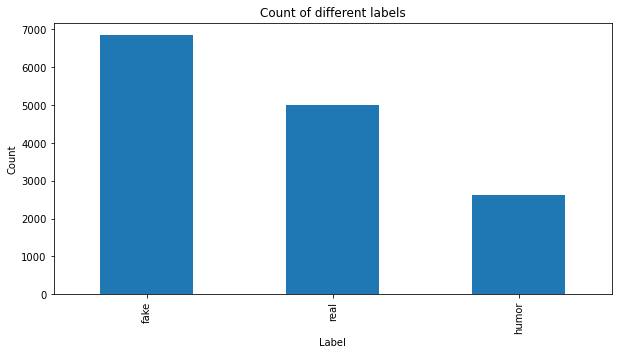

In [12]:
train_new_df['label'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title("Count of different labels")
plt.ylabel('Count')
plt.xlabel('Label')

Text(0.5, 0, 'Label')

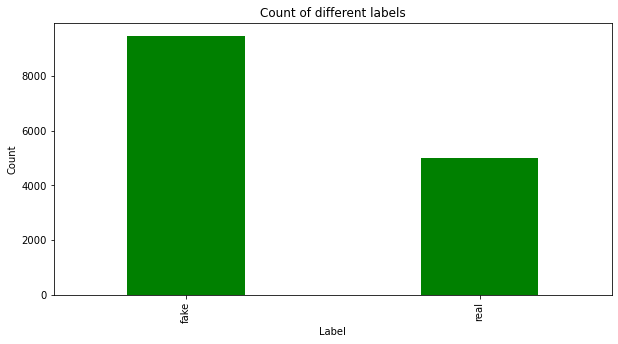

In [32]:
# for i in range(0, train_new_df['label'].count()):
#     label = train_new_df['label'][i]
#     if (label == 'humor') or (label == 'fake'):
#         train_new_df['new_label'][i] = 'fake'
#     else:
#         train_new_df['new_label'][i] = 'real'

        
# print(train_new_df['tweetText'][7867])
# print(train_new_df['new_label'][7867])
# print(train_new_df['label'][7867])
train_new_df['new_label'].value_counts().plot(kind='bar', width=0.4, figsize=(10,5), color=['green'])
plt.title("Count of different labels")
plt.ylabel('Count')
plt.xlabel('Label')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

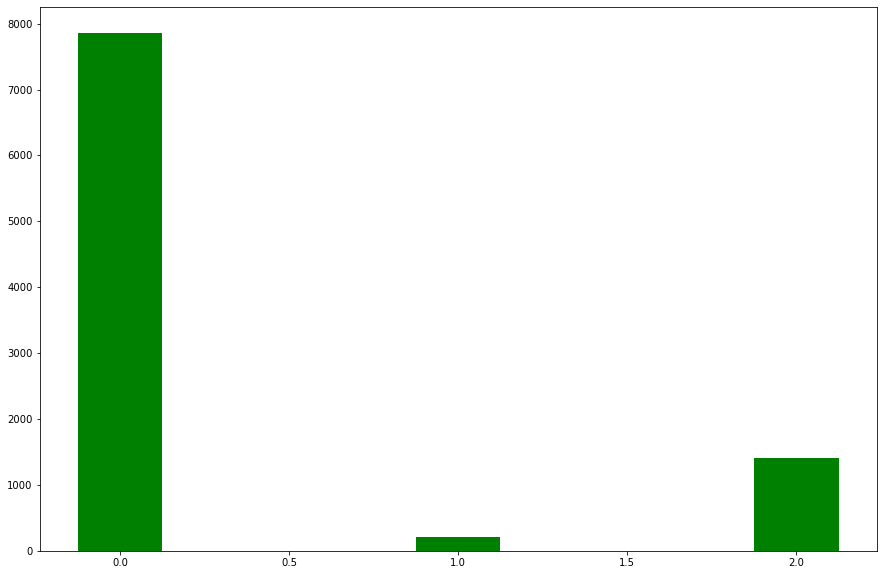

In [157]:
plt.figure(figsize=[15,10])
fake = [7858, 202, 1414]
real = [4665, 344]
X = np.arange(3)

plt.bar(X, real, color='green', width=0.25)
plt.bar(X + 0.25, fake, color='red', width=0.25)

plt.legend(['Real texts', 'Fake texts'])

plt.xticks([i + 0.25 for i in range(len(train_new_df['year'].value_counts().index.tolist()))], train_new_df['year'].value_counts().index.tolist())

plt.title("Real or fake tweets based on year")

plt.ylabel('Count')
plt.xlabel('Year')

plt.show()

#train_new_df['year'].value_counts().plot(kind="barh", figsize=[10,5])

In [156]:
train_new_df['year'].groupby(train_new_df['new_label']).value_counts()

new_label  year
fake       2012    7858
           2014    1414
           2013     202
real       2012    4665
           2013     344
Name: year, dtype: int64

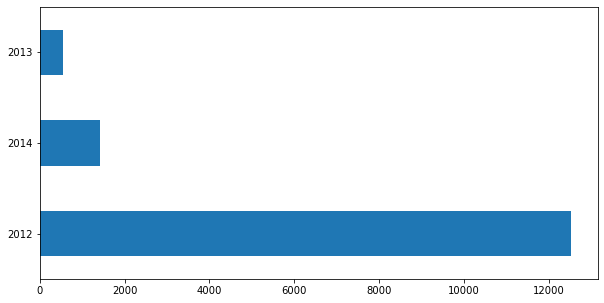

In [154]:
train_new_df['year'].value_counts().plot(kind="barh", figsize=[10,5])

In [24]:
######## Timestamp needs to be formatted as the time contains space - HH: MM: SS

def time_validate(timestamp):
    ts_format = "%a %b %d %H:%M:%S %z %Y"
    try:
        timestamp = dt.strptime(timestamp, ts_format)
    except ValueError:
        return False

for i in range(0, train_new_df['timestamp'].count()):
    time = train_new_df['timestamp'][i]
    if time_validate(time) == False:
        repaired_time = time[11:21].replace(' ', '')
        time = time.replace(time[11:21], repaired_time)
        if time_validate(time) != False:
            train_new_df['timestamp'][i] = time

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [27]:
train_new_df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14483 entries, 0 to 14482
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweetId     14483 non-null  int64              
 1   tweetText   14483 non-null  object             
 2   userId      14483 non-null  int64              
 3   imageId(s)  14483 non-null  object             
 4   username    14483 non-null  object             
 5   timestamp   14483 non-null  datetime64[ns, UTC]
 6   label       14483 non-null  object             
 7   new_label   14483 non-null  object             
 8   date        14483 non-null  object             
 9   time        14483 non-null  object             
 10  year        14483 non-null  int64              
 11  day         14483 non-null  int64              
 12  month       14483 non-null  int64              
 13  quarter     14483 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(6), o

In [26]:
######## Seperate timestamp into date, time, month year etc

train_new_df['timestamp'] = pd.to_datetime(train_new_df['timestamp'])
train_new_df['date'] = train_new_df['timestamp'].dt.date
train_new_df['time'] = train_new_df['timestamp'].dt.time
train_new_df['year'] = train_new_df['timestamp'].dt.year
train_new_df['day'] = train_new_df['timestamp'].dt.day
train_new_df['month'] = train_new_df['timestamp'].dt.month
train_new_df['quarter'] = train_new_df['timestamp'].dt.quarter

In [210]:
train_new_df

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,date,time,year,day,month,quarter
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,2012-10-29 22:34:01+00:00,fake,2012-10-29,22:34:01,2012,29,10,4
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,2012-10-29 19:11:23+00:00,fake,2012-10-29,19:11:23,2012,29,10,4
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,2012-10-29 18:11:08+00:00,fake,2012-10-29,18:11:08,2012,29,10,4
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,2012-10-29 19:15:33+00:00,fake,2012-10-29,19:15:33,2012,29,10,4
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,2012-10-29 20:46:02+00:00,fake,2012-10-29,20:46:02,2012,29,10,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,443231991593304064,@BobombDom *slaps TweetDeck with the PigFish h...,2179310905,pigFish_01,Da_Vault_Hunter,2014-03-11 03:48:36+00:00,fake,2014-03-11,03:48:36,2014,11,3,1
14479,443086239127076865,New Species of Fish found in Brazil or just Re...,254843101,pigFish_01,DjSituation_RC,2014-03-10 18:09:26+00:00,fake,2014-03-10,18:09:26,2014,10,3,1
14480,442978105238753280,What do we call this? #pigFISH http: \/\/t.co\...,2367553228,pigFish_01,Vivo1Vuyo,2014-03-10 10:59:45+00:00,fake,2014-03-10,10:59:45,2014,10,3,1
14481,442753479782989824,Pigfish ? E dopo il pescecane c'è il pesce mai...,603120231,pigFish_01,CosimoTarta,2014-03-09 20:07:10+00:00,fake,2014-03-09,20:07:10,2014,9,3,1


In [118]:
def remove_alpha_num_words(text):    
    ###### Remove words which are alpha-numeric or numeric
    text = text.apply(lambda x: re.sub('\w*\d\w*', '', x))
    return text
    
print(remove_alpha_num_words(train_processed_df['tweetText'][1]))

AttributeError: 'str' object has no attribute 'apply'

In [228]:
####### Formatting tweets as per requirement

# Remove hyperlinks
def remove_links(text):
    url = '((http|https)\://t.co\/[a-zA-Z0-9]+)|(http://|https://|http|https)|((http|https)\:\s\\\/\\\/t.co\\\/[a-zA-Z0-9]+)'
    return re.sub(url, "", text)

# Translate non-english tweets to english tweets
def translate_lang(text):
    translator = google_translator()
    return translator.translate(text, lang_tgt='en')

####### Loop through training data multiple times in sets of 2000-3000 rows inorder to 
####### translate the tweets without any error ---> train_new_df['tweetText'].count()
for i in range(12000, train_new_df['tweetText'].count()):           
    train_new_df['tweetText'][i] = remove_links(train_new_df['tweetText'][i])
    train_new_df['tweetText'][i] = translate_lang(train_new_df['tweetText'][i])
    

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [238]:
def remove_links(text):
    url = '((http|https)\://t.co\/[a-zA-Z0-9]+)|(http://|https://|http|https)|((http|https)\:\s\\\/\\\/t.co\\\/[a-zA-Z0-9]+)'
    pattern = '(:\s+\\\\s+\/\s+\\\s+\/t.co\s+\\\s+\/\s+[a-zA-Z0-9]+)|((t.co)+)'
    return re.sub(pattern, "", text)

for i in range(0, train_new_df['tweetText'].count()):
    train_new_df['tweetText'][i] = remove_links(train_new_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


#### Convert to CSV file

In [239]:
###### Until links removal
train_new_df.to_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_processed.csv", index=None)

In [18]:
###### Until punctuation removal
train_processed_df.to_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_processed1.csv", index=None)

In [19]:
###### Until no stopwords
train_processed_df.to_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_processed2.csv", index=None)

In [23]:
###### Until Lemmatization
train_processed_df.to_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_processed3.csv", index=None)

#### Read from CSV 

In [111]:
train_processed_df = pd.read_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_processed3.csv", encoding='utf-8')

In [5]:
train_count_df = pd.read_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/train_count_vect.csv", encoding='utf-8')

#### Apply NLP 

In [77]:
####### Remove junk character
def remove_junk_char(text):
    return text.encode("ascii", "ignore").decode("utf-8", "ignore")

for i in range(0, train_processed_df['tweetText'].count()):
    train_processed_df['tweetText'][i] = remove_junk_char(train_processed_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
def apply_nlp(text):
    
    ###### Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    ###### Tokenize tweets
    text = word_tokenize(text.lower())
    
    ###### Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    
    ###### Apply lemmatization
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    
    return text

In [73]:
for i in range(0, train_processed_df['tweetText'].count()):
    train_processed_df['tweetText'][i] = apply_nlp(train_processed_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [79]:
train_processed_df['tweetText']

0        Do you remember the movie: "The day after tomo...
1        @Milenagimon: Look at Sandy in NY! Tremendous ...
2        Good Hurricane Sandy's photo, reminds me of th...
3                               Scary Shit #Hurricane #No 
4        My fave place in the world #nyc #hurricane #sa...
                               ...                        
14478       @BobombDom *slaps TweetDeck with the PigFish  
14479    New Species of Fish found in Brazil or just Re...
14480                     What do we call this? #pigFISH  
14481    Pigfish? And after the fish is the pig fish ??...
14482    For those who can't decide between fish or mea...
Name: tweetText, Length: 14483, dtype: object

In [80]:
###### Count Vectorization

count_vect = CountVectorizer(analyzer=apply_nlp)
counts = count_vect.fit_transform(train_processed_df['tweetText'])
pickle.dump(count_vect, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/count_vect_model.pkl', 'wb'))
train_count_df = pd.DataFrame(counts.toarray())
train_count_df.columns = count_vect.get_feature_names()
print(counts.shape)
print(count_vect.get_feature_names())
train_count_df

(14483, 11506)
['0', '000', '00mustanggt', '05', '0620', '0635', '066', '0emiliebeth0', '0o', '1', '10', '100', '1000', '10000', '10001', '1002', '100k', '1017', '1029', '102912', '10292012', '1030', '103012', '10302012', '103040088', '10minago', '10p', '10pm', '10th', '11', '1134362n', '12', '12202012', '12ft', '13', '131', '132004', '132733', '134poet', '1388', '13damage', '13h', '14', '142nd', '145185km', '14st', '14th', '14thstreet', '14yroldetard', '15', '15323', '15feet', '15h', '15th', '16', '1600', '166st', '17', '1800', '18002255324', '1800callfbi', '1800callfbivia', '1848', '1886', '19', '1926', '1937', '1948', '1960', '19990', '19yearold', '1dmomentsbr', '1ground', '1hcrfan', '1manueltorres', '1respect', '1sivd33y1j', '1st', '1wtc', '1yson', '2', '20', '200', '2005', '2009', '200tahun', '201', '2012', '2012ntaxisflood', '2012problems', '2013', '2014', '2014cm331b1', '2014confab', '2014olympicproblems', '2016', '202hurricanesandy', '20th', '21122012endofworldhurricane', '217'

,0,000,00mustanggt,05,0620,0635,066,0emiliebeth0,0o,1,...,zone,zone0,zoo,zoofrikin,zoom,zprophetmma,zuko,zule,zupa2732,zuul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14480,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14481,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Create features 

In [6]:
###### Create feature which calculates text length 

train_processed_df['tweetText_len'] = train_processed_df['tweetText'].apply(lambda x: len(x) - x.count(" "))

train_features_df = pd.concat([train_processed_df['tweetText_len'], train_count_df], axis=1)
train_features_df

,tweetText_len,0,000,00mustanggt,05,0620,0635,066,0emiliebeth0,0o,...,zone,zone0,zoo,zoofrikin,zoom,zprophetmma,zuko,zule,zupa2732,zuul
0,86,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,89,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,53,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14478,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14479,66,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14480,23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14481,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Cleaning Test dataset

In [10]:
####### Same procedure as training data

test_path = "D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/mediaeval-2015-testset.txt"
new_test_path = "D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/testset.txt"

with open(test_path, encoding="utf-8") as ftestin, open(new_test_path, 'w', encoding="utf-8") as ftestout:
    
    for row in ftestin:
        ftestout.write("<>".join(row.split("\t")))

In [11]:
test_df = pd.read_csv(new_test_path, sep="<>", encoding="utf-8")
test_df

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake
4,578975333841551360,"""@ebonfigli: Éclipse vue de l'ISS... Autre cho...",1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake
...,...,...,...,...,...,...,...
3776,578433150071775232,Un présentateur de la ZDF confesse avoir truqu...,257551211,varoufakis_1,Cdt_Sylvestre,Thu Mar 19 05:49:44 +0000 2015,fake
3777,578433646597656576,"Oh les kleine menteurs ""@CorineBarella: Un pré...",27575883,varoufakis_1,damomarc,Thu Mar 19 05:51:42 +0000 2015,fake
3778,578486910491996160,Este es el programa de ZDF en el que confirman...,2049211,varoufakis_1,javierpascual,Thu Mar 19 09:23:21 +0000 2015,fake
3779,578505023912591360,11.34 - wir haben FAST Mittag ▶ Riesen Verwirr...,262222386,varoufakis_1,aotto1968_2,Thu Mar 19 10:35:20 +0000 2015,fake


In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3781 entries, 0 to 3780
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweetId     3781 non-null   int64              
 1   tweetText   3781 non-null   object             
 2   userId      3781 non-null   int64              
 3   imageId(s)  3781 non-null   object             
 4   username    3781 non-null   object             
 5   timestamp   3781 non-null   datetime64[ns, UTC]
 6   label       3781 non-null   object             
 7   date        3781 non-null   object             
 8   time        3781 non-null   object             
 9   year        3781 non-null   int64              
 10  day         3781 non-null   int64              
 11  month       3781 non-null   int64              
 12  quarter     3781 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(6), object(6)
memory usage: 384.1+ KB


In [14]:
######## Timestamp needs to be formatted as the time contains space - HH: MM: SS

def time_validate(timestamp):
    ts_format = "%a %b %d %H:%M:%S %z %Y"
    try:
        timestamp = dt.strptime(timestamp, ts_format)
    except ValueError:
        return False

for i in range(0, test_df['timestamp'].count()):
    time = test_df['timestamp'][i]
    if time_validate(time) == False:
        repaired_time = time[11:21].replace(' ', '')
        time = time.replace(time[11:21], repaired_time)
        if time_validate(time) != False:
            test_df['timestamp'][i] = time

In [16]:
######## Seperate timestamp into date, time, month year etc

test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['date'] = test_df['timestamp'].dt.date
test_df['time'] = test_df['timestamp'].dt.time
test_df['year'] = test_df['timestamp'].dt.year
test_df['day'] = test_df['timestamp'].dt.day
test_df['month'] = test_df['timestamp'].dt.month
test_df['quarter'] = test_df['timestamp'].dt.quarter

In [46]:
###### Until time format
test_df.to_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/test_df4.csv", index=None)

In [81]:
###### Retrieve from CSV
test_df = pd.read_csv("D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/test_df2.csv", encoding='utf-8')

In [24]:
####### Formatting tweets as per requirement

# Remove hyperlinks
def remove_links(text):
    url = '((http|https)\://t.co\/[a-zA-Z0-9]+)|(http://|https://|http|https)|((http|https)\:\s\\\/\\\/t.co\\\/[a-zA-Z0-9]+)'
    #pattern = '(:\s+\\\\s+\/\s+\\\s+\/t.co\s+\\\s+\/\s+[a-zA-Z0-9]+)|((t.co)+)'
    return re.sub(url, "", text)

# Translate non-english tweets to english tweets
def translate_lang(text):
    translator = google_translator()
    return translator.translate(text, lang_tgt='en')

####### Loop through training data multiple times in sets of 2000-3000 rows inorder to 
####### translate the tweets without any error ---> train_new_df['tweetText'].count()
for i in range(3000, test_df['tweetText'].count()):           
    test_df['tweetText'][i] = remove_links(test_df['tweetText'][i])
    test_df['tweetText'][i] = translate_lang(test_df['tweetText'][i])
    

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [35]:
def remove_links(text):
    url = '((http|https)\://t.co\/[a-zA-Z0-9]+)|(http://|https://|http|https)|((http|https)\:\s\\\/\\\/t.co\\\/[a-zA-Z0-9]+)'
    pattern = '(:\s+\\\\s+\/\s+\\\s+\/t.co\s+\\\s+\/\s+[a-zA-Z0-9]+)|((t.co)+)'
    return re.sub(pattern, "", text)

for i in range(0, test_df['tweetText'].count()):
    test_df['tweetText'][i] = remove_links(test_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [82]:
####### Remove junk character
def remove_junk_char(text):
    return text.encode("ascii", "ignore").decode("utf-8", "ignore")

for i in range(0, test_df['tweetText'].count()):
    test_df['tweetText'][i] = remove_junk_char(test_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [40]:
def apply_nlp(text):
    
    ###### Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    
    ###### Tokenize tweets
    text = word_tokenize(text.lower())
    
    ###### Remove stop words
    stopwords = nltk.corpus.stopwords.words('english')
    text = [word for word in text if word not in stopwords]
    
    ###### Apply lemmatization
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    
    return text

for i in range(0, test_df['tweetText'].count()):
    test_df['tweetText'][i] = apply_nlp(test_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
def apply_nlp(text):
    
    ###### Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    return text

for i in range(0, test_df['tweetText'].count()):
    test_df['tweetText'][i] = apply_nlp(test_df['tweetText'][i])

C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
###### Count Vectorization

count_vect_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/count_vect_model.pkl', 'rb'))
counts = count_vect_model.transform(test_df['tweetText'])
test_count_df = pd.DataFrame(counts.toarray())
test_count_df.columns = count_vect.get_feature_names()
print(counts.shape)
print(count_vect.get_feature_names())
test_count_df.head(10)

(3781, 11506)
['0', '000', '00mustanggt', '05', '0620', '0635', '066', '0emiliebeth0', '0o', '1', '10', '100', '1000', '10000', '10001', '1002', '100k', '1017', '1029', '102912', '10292012', '1030', '103012', '10302012', '103040088', '10minago', '10p', '10pm', '10th', '11', '1134362n', '12', '12202012', '12ft', '13', '131', '132004', '132733', '134poet', '1388', '13damage', '13h', '14', '142nd', '145185km', '14st', '14th', '14thstreet', '14yroldetard', '15', '15323', '15feet', '15h', '15th', '16', '1600', '166st', '17', '1800', '18002255324', '1800callfbi', '1800callfbivia', '1848', '1886', '19', '1926', '1937', '1948', '1960', '19990', '19yearold', '1dmomentsbr', '1ground', '1hcrfan', '1manueltorres', '1respect', '1sivd33y1j', '1st', '1wtc', '1yson', '2', '20', '200', '2005', '2009', '200tahun', '201', '2012', '2012ntaxisflood', '2012problems', '2013', '2014', '2014cm331b1', '2014confab', '2014olympicproblems', '2016', '202hurricanesandy', '20th', '21122012endofworldhurricane', '217',

,0,000,00mustanggt,05,0620,0635,066,0emiliebeth0,0o,1,...,zone,zone0,zoo,zoofrikin,zoom,zprophetmma,zuko,zule,zupa2732,zuul
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
###### Create feature which calculates text length 

test_df['tweetText_len'] = test_df['tweetText'].apply(lambda x: len(x) - x.count(" "))

test_features_df = pd.concat([test_df['tweetText_len'], test_count_df], axis=1)
test_features_df

,tweetText_len,0,000,00mustanggt,05,0620,0635,066,0emiliebeth0,0o,...,zone,zone0,zoo,zoofrikin,zoom,zprophetmma,zuko,zule,zupa2732,zuul
0,37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,76,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,83,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3776,96,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3777,90,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3778,68,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3779,77,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creating Models 

### Random Forest 

In [50]:
param_grid = [{
    'n_estimators' : [100, 200, 300],
    'max_depth' : [30, 60, 90, None]
}]
    

rfc = RandomForestClassifier()

rfc_grid_model = GridSearchCV(rfc, param_grid, n_jobs=7, cv=5, verbose=2)
rfc_model = rfc_grid_model.fit(train_features_df, train_processed_df['label'])
print(rfc_grid_model.best_params_)

rcf_df = pd.DataFrame(rfc_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
print(rcf_df)
rcf_df.to_csv('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/RandomForest(CV).csv')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:  4.8min
[Parallel(n_jobs=7)]: Done  60 out of  60 | elapsed: 18.3min finished


{'max_depth': None, 'n_estimators': 100}
    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9      105.438909      2.691085         1.098399        0.137455   
10     209.142051     10.071191         1.698101        0.288359   
11     267.916907     25.750169         1.420599        0.342899   
6       64.919504      3.533063         0.642891        0.077500   
8      191.730312      4.196539         1.219400        0.152474   

   param_max_depth param_n_estimators  \
9             None                100   
10            None                200   
11            None                300   
6               90                100   
8               90                300   

                                      params  split0_test_score  \
9   {'max_depth': None, 'n_estimators': 100}           0.599586   
10  {'max_depth': None, 'n_estimators': 200}           0.593372   
11  {'max_depth': None, 'n_estimators': 300}           0.591647   
6     {'max_depth': 90, 'n_estimato

#### Train-test split 

In [5]:
XRF_train, XRF_test, yrf_train, yrf_test = train_test_split(train_features_df, train_processed_df['label'], test_size=0.2)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=7)
rf_model = rf.fit(XRF_train, yrf_train)
sorted(zip(rf_model.feature_importances_,  XRF_train.columns), reverse=True)[0:10]
yrf_pred = rf_model.predict(XRF_test)

#precision, recall, fscore, support = score(yrf_test, yrf_pred, pos_label='fake', average='binary')
#print("Precision: {} / Recall: {} / Accuracy: {} / ".format(round(precision, 3), round(recall, 3), round((yrf_pred == yrf_test).sum() / len(yrf_pred), 3)))

Accuracy: 0.8167069382119434
Precision: 0.8167069382119434
Recall: 0.8167069382119434
              precision    recall  f1-score   support

        fake       0.92      0.76      0.83      1666
       humor       0.56      0.78      0.65       376
        real       0.81      0.94      0.87       855

    accuracy                           0.82      2897
   macro avg       0.76      0.83      0.79      2897
weighted avg       0.84      0.82      0.82      2897



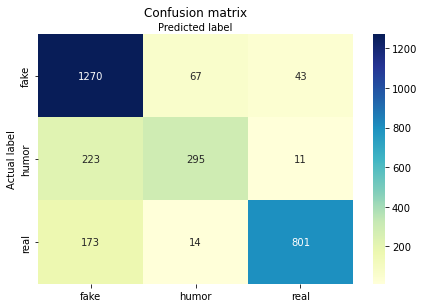

In [6]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(yrf_test, yrf_pred)

class_names = list(np.unique(train_processed_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(yrf_test, yrf_pred))
print("Precision:",metrics.precision_score(yrf_test, yrf_pred,average='micro'))
print("Recall:",metrics.recall_score(yrf_test, yrf_pred,average='micro'))

LabelScore = metrics.classification_report(yrf_pred, yrf_test)
print(LabelScore)

In [10]:
##### Storing model
pickle.dump(rf, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/rf_model.pkl', 'wb'))

#### On test data 

Accuracy: 0.6638455435070088
Precision: 0.6638455435070088
Recall: 0.6638455435070088
              precision    recall  f1-score   support

        fake       0.98      0.67      0.80      3715
       humor       0.00      0.00      0.00         1
        real       0.00      0.09      0.01        65

    accuracy                           0.66      3781
   macro avg       0.33      0.26      0.27      3781
weighted avg       0.96      0.66      0.78      3781



C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


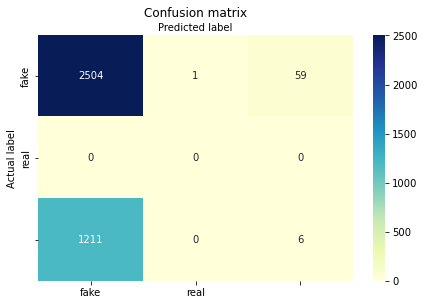

In [85]:
rf_test_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/rf_model.pkl', 'rb'))
test_pred = rf_test_model.predict(test_features_df)

cnf_matrix = metrics.confusion_matrix(test_df['label'], test_pred)

class_names = list(np.unique(test_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix_rf_test.png')

print("Accuracy:",metrics.accuracy_score(test_df['label'], test_pred))
print("Precision:",metrics.precision_score(test_df['label'], test_pred,average='micro'))
print("Recall:",metrics.recall_score(test_df['label'], test_pred,average='micro'))

LabelScore = metrics.classification_report(test_pred, test_df['label'])
print(LabelScore)

###  Gradient Boosting

In [6]:
gb_param_grid = [{
    'n_estimators' : [100, 150],
    'max_depth' : [10, 15],
    'learning_rate' : [0.1],
    'verbose' : [1]
}]

gb = GradientBoostingClassifier()

gb_grid_model = GridSearchCV(gb, gb_param_grid, cv=5, n_jobs=7, verbose=2)
gb_model = gb_grid_model.fit(train_features_df, train_processed_df['label'])
print(gb_grid_model.best_params_)

gb_df = pd.DataFrame(gb_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
gb_df
gb_df.to_csv('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/GradientBoosting(CV).csv')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  18 out of  20 | elapsed: 171.0min remaining: 19.0min
[Parallel(n_jobs=7)]: Done  20 out of  20 | elapsed: 175.3min finished


      Iter       Train Loss   Remaining Time 
         1           0.9790           27.65m
         2           0.9336           27.29m
         3           0.8983           27.25m
         4           0.8681           27.15m
         5           0.8416           27.06m
         6           0.8190           26.99m
         7           0.7989           26.87m
         8           0.7806           26.75m
         9           0.7637           26.58m
        10           0.7488           26.46m
        20           0.6484           25.71m
        30           0.5954           24.73m
        40           0.5616           23.37m
        50           0.5353           21.65m
        60           0.5140           19.72m
        70           0.4959           17.68m
        80           0.4802           15.58m
        90           0.4668           13.43m
       100           0.4553           11.25m
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150, 'verbose': 1}


#### Train-test split 

In [106]:
XGB_train, XGB_test, ygb_train, ygb_test = train_test_split(train_features_df, train_processed_df['label'], test_size=0.2)
gb = GradientBoostingClassifier(n_estimators=150, max_depth=10, learning_rate=0.1)
gb_model = gb.fit(XGB_train, ygb_train)
#sorted(zip(gb_model.feature_importances_, XGB_train.columns), reverse=True)[0:10]
ygb_pred = gb_model.predict(XGB_test)

Accuracy: 0.7890921643079047
Precision: 0.7890921643079047
Recall: 0.7890921643079047
              precision    recall  f1-score   support

        fake       0.91      0.72      0.81      1678
       humor       0.46      0.76      0.58       316
        real       0.80      0.92      0.85       903

    accuracy                           0.79      2897
   macro avg       0.72      0.80      0.75      2897
weighted avg       0.83      0.79      0.80      2897



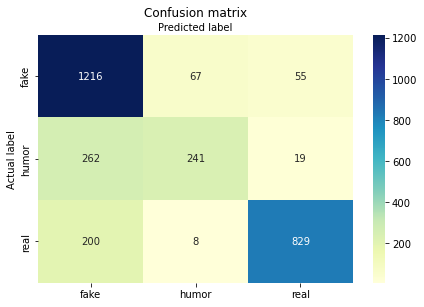

In [107]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(ygb_test, ygb_pred)

class_names = list(np.unique(train_processed_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(ygb_test, ygb_pred))
print("Precision:",metrics.precision_score(ygb_test, ygb_pred,average='micro'))
print("Recall:",metrics.recall_score(ygb_test, ygb_pred,average='micro'))

LabelScore = metrics.classification_report(ygb_pred, ygb_test)
print(LabelScore)

In [108]:
##### Storing model
pickle.dump(gb, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/gb_model.pkl', 'wb'))

#### On test data 

Accuracy: 0.6466543242528432
Precision: 0.6466543242528432
Recall: 0.6466543242528432
              precision    recall  f1-score   support

        fake       0.94      0.67      0.78      3604
       humor       0.00      0.00      0.00        34
        real       0.02      0.20      0.04       143

    accuracy                           0.65      3781
   macro avg       0.32      0.29      0.27      3781
weighted avg       0.90      0.65      0.75      3781



C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


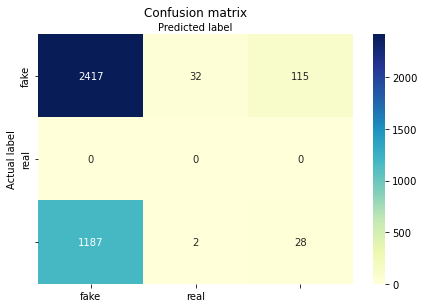

In [109]:
gb_test_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/gb_model.pkl', 'rb'))
test_pred = gb_test_model.predict(test_features_df)

cnf_matrix = metrics.confusion_matrix(test_df['label'], test_pred)

class_names = list(np.unique(test_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix_gb_test.png')

print("Accuracy:",metrics.accuracy_score(test_df['label'], test_pred))
print("Precision:",metrics.precision_score(test_df['label'], test_pred,average='micro'))
print("Recall:",metrics.recall_score(test_df['label'], test_pred,average='micro'))

LabelScore = metrics.classification_report(test_pred, test_df['label'])
print(LabelScore)

### Support Vector Classifier 

In [8]:
svc_param_grid = [{
    'C' : [1],
    'kernel' : ['linear', 'rbf'],
    'degree' : [2, 3],
    'gamma' : ['auto', 'scale']
}]

svc = SVC()

svc_grid_model = GridSearchCV(svc, svc_param_grid, cv=5, n_jobs=7, verbose=2)
svc_model = svc_grid_model.fit(train_features_df, train_processed_df['label'])
print(svc_grid_model.best_params_)

svc_df = pd.DataFrame(svc_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
svc_df
svc_df.to_csv('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/SVC(CV).csv')

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed: 169.2min
[Parallel(n_jobs=7)]: Done  40 out of  40 | elapsed: 228.8min finished


{'C': 1, 'degree': 2, 'gamma': 'auto', 'kernel': 'linear'}


#### Train-test split 

In [14]:
XSVC_train, XSVC_test, ysvc_train, ysvc_test = train_test_split(train_features_df, train_processed_df['label'], test_size=0.2)
svc = SVC(C=1, kernel='linear', degree=3, gamma='auto')
svc_model = svc.fit(XSVC_train, ysvc_train)
#sorted(zip(svc_model.feature_importances_, XSVC_train.columns), reverse=True)[0:10]
ysvc_pred = svc_model.predict(XSVC_test)

AttributeError: 'SVC' object has no attribute 'feature_importances_'

In [15]:
svc_pred = svc_model.predict(XSVC_test)

Accuracy: 0.7959958577839144
Precision: 0.7959958577839144
Recall: 0.7959958577839144
              precision    recall  f1-score   support

        fake       0.88      0.77      0.82      1593
       humor       0.56      0.70      0.62       433
        real       0.81      0.89      0.85       871

    accuracy                           0.80      2897
   macro avg       0.75      0.79      0.76      2897
weighted avg       0.81      0.80      0.80      2897



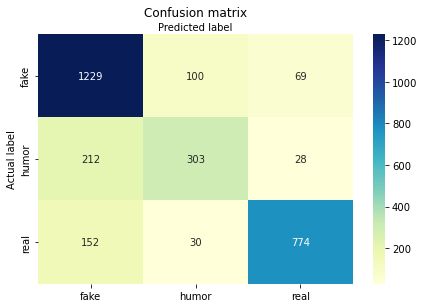

In [18]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(ysvc_test, svc_pred)

class_names = list(np.unique(train_processed_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(ysvc_test, svc_pred))
print("Precision:",metrics.precision_score(ysvc_test, svc_pred,average='micro'))
print("Recall:",metrics.recall_score(ysvc_test, svc_pred,average='micro'))

LabelScore = metrics.classification_report(svc_pred, ysvc_test)
print(LabelScore)

In [19]:
##### Storing model
pickle.dump(svc, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/svc_model.pkl', 'wb'))

#### On test data 

Accuracy: 0.6540597725469453
Precision: 0.6540597725469453
Recall: 0.6540597725469453
              precision    recall  f1-score   support

        fake       0.58      0.90      0.71      1642
       humor       0.00      0.00      0.00       233
        real       0.81      0.52      0.63      1906

    accuracy                           0.65      3781
   macro avg       0.46      0.47      0.45      3781
weighted avg       0.66      0.65      0.63      3781



C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


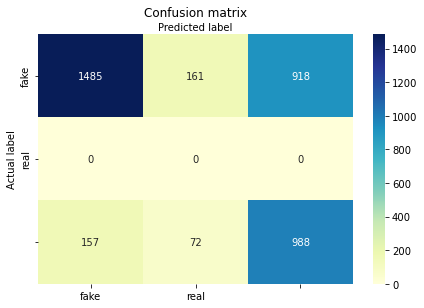

In [103]:
svc_test_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/svc_model.pkl', 'rb'))
test_pred = svc_test_model.predict(test_features_df)

cnf_matrix = metrics.confusion_matrix(test_df['label'], test_pred)

class_names = list(np.unique(test_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix_svc_test.png')

print("Accuracy:",metrics.accuracy_score(test_df['label'], test_pred))
print("Precision:",metrics.precision_score(test_df['label'], test_pred,average='micro'))
print("Recall:",metrics.recall_score(test_df['label'], test_pred,average='micro'))

LabelScore = metrics.classification_report(test_pred, test_df['label'])
print(LabelScore)

### Multinomial Naive Bayes 

In [ ]:
mnb = MultinomialNB()

mnb_grid_model = GridSearchCV(mnb, cv=5, n_jobs=7, verbose=2)
mnb_model = mnb_grid_model.fit(train_features_df, train_processed_df['label'])
print(mnb_grid_model.best_params_)

mnb_df = pd.DataFrame(mnb_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
mnb_df
mnb_df.to_csv('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/MNB(CV).csv')

#### Train-test split 

In [20]:
XMNB_train, XMNB_test, ymnb_train, ymnb_test = train_test_split(train_features_df, train_processed_df['label'], test_size=0.2)
mnb = MultinomialNB()
mnb_model = mnb.fit(XMNB_train, ymnb_train)
#sorted(zip(svc_model.feature_importances_, XMNB_train.columns), reverse=True)[0:10]
ymnb_pred = mnb_model.predict(XMNB_test)

Accuracy: 0.7694166379012772
Precision: 0.7694166379012772
Recall: 0.7694166379012772
              precision    recall  f1-score   support

        fake       0.89      0.73      0.80      1703
       humor       0.39      0.74      0.51       278
        real       0.80      0.85      0.83       916

    accuracy                           0.77      2897
   macro avg       0.69      0.77      0.71      2897
weighted avg       0.82      0.77      0.78      2897



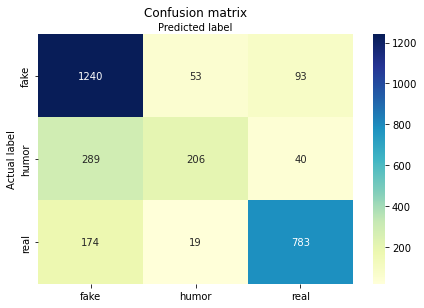

In [21]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(ymnb_test, ymnb_pred)

class_names = list(np.unique(train_processed_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(ymnb_test, ymnb_pred))
print("Precision:",metrics.precision_score(ymnb_test, ymnb_pred,average='micro'))
print("Recall:",metrics.recall_score(ymnb_test, ymnb_pred,average='micro'))

LabelScore = metrics.classification_report(ymnb_pred, ymnb_test)
print(LabelScore)

In [22]:
##### Storing model
pickle.dump(mnb, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/mnb_model.pkl', 'wb'))

#### On test data 

Accuracy: 0.6839460460195715
Precision: 0.6839460460195715
Recall: 0.6839460460195715
              precision    recall  f1-score   support

        fake       0.64      0.86      0.73      1912
       humor       0.00      0.00      0.00         3
        real       0.78      0.51      0.61      1866

    accuracy                           0.68      3781
   macro avg       0.47      0.45      0.45      3781
weighted avg       0.71      0.68      0.67      3781



C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


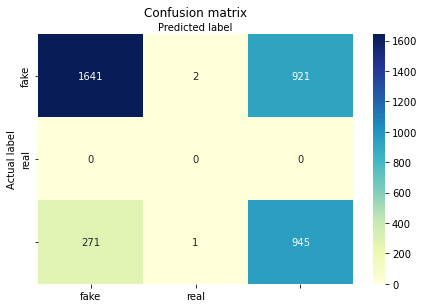

In [104]:
mnb_test_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/mnb_model.pkl', 'rb'))
test_pred = mnb_test_model.predict(test_features_df)

cnf_matrix = metrics.confusion_matrix(test_df['label'], test_pred)

class_names = list(np.unique(test_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix_mnb_test.png')

print("Accuracy:",metrics.accuracy_score(test_df['label'], test_pred))
print("Precision:",metrics.precision_score(test_df['label'], test_pred,average='micro'))
print("Recall:",metrics.recall_score(test_df['label'], test_pred,average='micro'))

LabelScore = metrics.classification_report(test_pred, test_df['label'])
print(LabelScore)

#### Logistic Regression 

In [ ]:
param_grid = [{
    'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'solver' : ['liblinear', 'sag', 'lbfgs'],
    'C' : [10],
}]
    

lr = LogisticRegression()

lr_grid_model = GridSearchCV(lr, param_grid, n_jobs=7, cv=5, verbose=2)
lr_model = lr_grid_model.fit(train_features_df, train_processed_df['label'])
print(lr_grid_model.best_params_)

lr_df = pd.DataFrame(lr_model.cv_results_).sort_values('mean_test_score', ascending=False)[0:5] 
print(lr_df)
lr_df.to_csv('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/LogisticRegression(CV).csv')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  27 tasks      | elapsed:   50.7s


#### Train-test split 

In [7]:
XLR_train, XLR_test, ylr_train, ylr_test = train_test_split(train_features_df, train_processed_df['label'], test_size=0.2)
lr = LogisticRegression(solver='liblinear', C=10, penalty='l2')
lr_model = lr.fit(XLR_train, ylr_train)
#sorted(zip(svc_model.feature_importances_, XMNB_train.columns), reverse=True)[0:10]
ylr_pred = lr_model.predict(XLR_test)

Accuracy: 0.8080773213669313
Precision: 0.8080773213669313
Recall: 0.8080773213669313
              precision    recall  f1-score   support

        fake       0.86      0.80      0.83      1506
       humor       0.60      0.69      0.64       438
        real       0.84      0.88      0.86       953

    accuracy                           0.81      2897
   macro avg       0.77      0.79      0.78      2897
weighted avg       0.81      0.81      0.81      2897



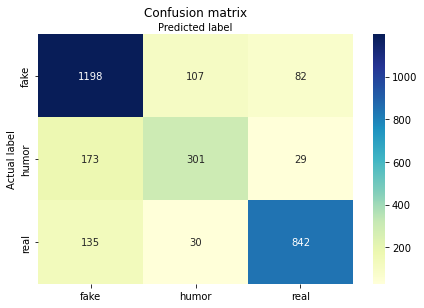

In [8]:
##### Create Confusion Matrix
cnf_matrix = metrics.confusion_matrix(ylr_test, ylr_pred)

class_names = list(np.unique(train_processed_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix.png')

print("Accuracy:",metrics.accuracy_score(ylr_test, ylr_pred))
print("Precision:",metrics.precision_score(ylr_test, ylr_pred,average='micro'))
print("Recall:",metrics.recall_score(ylr_test, ylr_pred,average='micro'))

LabelScore = metrics.classification_report(ylr_pred, ylr_test)
print(LabelScore)

In [9]:
##### Storing model
pickle.dump(lr, open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/lr_model.pkl', 'wb'))

#### On test data 

Accuracy: 0.7283787357841841
Precision: 0.7283787357841841
Recall: 0.7283787357841841
              precision    recall  f1-score   support

        fake       0.70      0.89      0.78      1999
       humor       0.00      0.00      0.00       106
        real       0.79      0.58      0.67      1676

    accuracy                           0.73      3781
   macro avg       0.50      0.49      0.48      3781
weighted avg       0.72      0.73      0.71      3781



C:\Users\Ashish S\.conda\envs\mlt\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


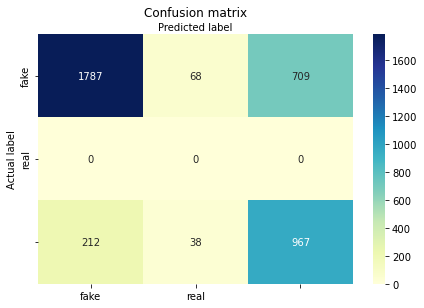

In [105]:
lr_test_model = pickle.load(open('D:/SOTON Material/ML Technologies/Proj/assignment-comp3222-comp6246-mediaeval2015-dataset/Assgnm/lr_model.pkl', 'rb'))
test_pred = lr_test_model.predict(test_features_df)

cnf_matrix = metrics.confusion_matrix(test_df['label'], test_pred)

class_names = list(np.unique(test_df['label'])) # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig('Confusion Matrix_lr_test.png')

print("Accuracy:",metrics.accuracy_score(test_df['label'], test_pred))
print("Precision:",metrics.precision_score(test_df['label'], test_pred,average='micro'))
print("Recall:",metrics.recall_score(test_df['label'], test_pred,average='micro'))

LabelScore = metrics.classification_report(test_pred, test_df['label'])
print(LabelScore)